# PoliDuckies
A notebook with the complete pipeline

### Standard imports

In [1]:
execution = 'local' #@param ['local', 'colab']

In [2]:
import os 
branch = "daffy" #@param ['master', 'daffy']

if not os.path.isdir('gym-duckietown') and not os.path.isdir('../gym-duckietown'):
  !git clone --branch {branch} https://github.com/duckietown/gym-duckietown.git
  !pip3 install -e gym-duckietown
if "/gym-duckietown" not in os.getcwd():
  os.chdir('gym-duckietown')
  
!pip install numpy
!apt install xvfb -y
!pip3 install pyvirtualdisplay
!pip install pyglet==1.5.14
!pip install duckietown-gym-daffy
!pip install poliduckie-segmentation
!pip install PTable
!pip install imageio

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.3-2ubuntu2.9).
0 upgraded, 0 newly installed, 0 to remove and 92 not upgraded.


In [3]:
from pyvirtualdisplay import Display
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
%matplotlib inline

## used to copy the model to the gdrive folder
import shutil

import cv2
import gym
import gym_duckietown
import pyglet

# Gym has a built in logger to log information. The information is split in importance levels, from highest to lowest:
# CRITICAL, ERROR, WARNING, INFO, DEBUG, NOTSET
# To stop gym from printing many verbose NOTSET, INFO and DEBUG messages we let it print only level WARNING or higher messages
import logging
gym_duckietown.logger.setLevel(logging.ERROR)

DEBUG:commons:version: 6.2.4 *
DEBUG:typing:version: 6.2.3
DEBUG:duckietown_world:duckietown-world version 6.4.3 path /usr/local/lib/python3.9/dist-packages
DEBUG:geometry:PyGeometry-z6 version 2.1.4 path /usr/local/lib/python3.9/dist-packages
DEBUG:aido_schemas:aido-protocols version 6.1.1 path /usr/local/lib/python3.9/dist-packages
DEBUG:nodes:version 6.2.17 path /usr/local/lib/python3.9/dist-packages pyparsing 2.4.7
DEBUG:gym-duckietown:gym-duckietown version 6.1.34 path /usr/local/lib/python3.9/dist-packages



{'audio': ('xaudio2', 'directsound', 'openal', 'pulse', 'silent'), 'debug_font': False, 'debug_gl': True, 'debug_gl_trace': False, 'debug_gl_trace_args': False, 'debug_graphics_batch': False, 'debug_lib': False, 'debug_media': False, 'debug_texture': False, 'debug_trace': False, 'debug_trace_args': False, 'debug_trace_depth': 1, 'debug_trace_flush': True, 'debug_win32': False, 'debug_x11': False, 'graphics_vbo': True, 'shadow_window': True, 'vsync': None, 'xsync': True, 'xlib_fullscreen_override_redirect': False, 'darwin_cocoa': True, 'search_local_libs': True}


In [4]:
map_name = "Duckietown-small_loop-v0"

### Methods

In [5]:
from poliduckie_segmentation.segmentation import Segmentation

seg = Segmentation()

def segmentation(image):
  """
    Returns the image from the simulation with the segmentation

    Image: np.Array
    ------
    Image: np.Array
  """
  resized = cv2.resize(image, (320, 240))
  return seg.predict(resized)

2023-04-08 12:35:32.873864: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-08 12:35:32.877482: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-08 12:35:32.923944: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-08 12:35:32.926358: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 12:35:33.601265: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 240, 320, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 320, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [6]:
if execution == 'colab':
    !wget https://github.com/poliduckie/poliduckie_pipeline/blob/SingleFixedDistanceReference/notebooks/BirdEyeMatrices/SegmentationOutput.pkl?raw=true
    !mv SegmentationOutput.pkl?raw=true SegmentationOutput.pkl

In [7]:
from poliduckie_segmentation import BirdEyeView

matrixPath = '../SegmentationOutput.pkl' if execution == 'colab' else '../BirdEyeMatrices/SegmentationOutput.pkl'

birdeye = BirdEyeView(path = matrixPath)

def birdEyeTransform(image):
  """
    Returns the image from the simulation with the bird eye view

    Image: np.Array
    ------
    Image: np.Array
  """
  return birdeye.computeBirdEye(image)

In [8]:
from poliduckie_segmentation.line_extraction import LineExtraction

LineExtraction.N_CLUSTERS = 10
LineExtraction.MIN_ENTRIES = 8
LineExtraction.MAX_DISTANCE = 40

lineExtraction_ = LineExtraction()

def lineExtraction(image, n_points=100, mode="bezier", bezier_degree=3, img_height=240, vertical_cutoff=150):
  """
    Returns the central line extracted as a numpy array. The mode can be either "bezier" or "spline"

    Image: np.Array
    n_points: int
    mode: str
    bezier_degree: int
    ------
    Line: np.Array
  """
  if(np.nonzero(image)[0].size < LineExtraction.N_CLUSTERS):
    return np.array([[320/2], [img_height-vertical_cutoff]])
  
  if mode == "bezier":
    bezier_points = lineExtraction_.bezier_fit(image, degree=bezier_degree, nPoints=n_points, usePCA=True)
    
    if bezier_points[1, -1] > bezier_points[1, 0]:
      bezier_points = bezier_points[:, ::-1]

    return bezier_points
  
  elif mode == "spline":
    spline_points = lineExtraction_.spline_interpolation(image, nPoints=n_points)
    return spline_points

In [23]:
METER_PER_PIXEL = 0.4 / 150
CAR_POSITION = [320/2, 0]

def computeReference(line, N, vertical_cutoff, img_size_y):
  """
    Returns the references in meters
    Reference is a list with dimension (2, N)
    N is the prediction horizon of the MPC

    Line: np.Array
    N: int
    ------
    reference: List[[List[Float], List[Float]]]
  """
  reference = line[:, :N].copy()

  #center around car position
  reference[0] = [x - CAR_POSITION[0] for x in reference[0]]
  reference[1] = [img_size_y - vertical_cutoff - y  for y in reference[1]]

  #convert to meters
  reference[0] = [x * METER_PER_PIXEL for x in reference[0]]
  reference[1] = [y * METER_PER_PIXEL for y in reference[1]]
  
  # reference = [[], []]
  # reference[0] = [0 for x in range(N)]
  # reference[1] = [y for y in range(N)]
  return np.array(reference)

In [10]:
from poliduckie_segmentation.control import MPC
N = 10
M = MPC(N=10)

def runMpc(state, reference):
  """
    Returns the control inputs to give to the car.
    State is [x, y, theta, v, w]
    Reference is a list with dimension (2, N)

    state: [Float, Float, Float, Float, Float]
    reference: List[[List[Float], List[Float]]]
    ------
    u: List[Float, Float]
  """
  return M.mpc(state, reference)

In [11]:
imageVisualization = 'Plt' #@param ['Plt', 'CV2']

def plt_imshow(image, **kwargs):
  ax = kwargs['ax']
  ax.imshow(image)

  if 'no_axis' in kwargs and kwargs['no_axis']:
    ax.axis('off')

  if 'show' in kwargs and kwargs['show']:
    plt.show()


if imageVisualization == 'CV2':
  from google.colab.patches import cv2_imshow
  imshow = cv2_imshow
else:
  imshow = plt_imshow

### Simulation

INFO:duckietown_world: data: /usr/local/lib/python3.9/dist-packages/duckietown_world/data
/usr/local/lib/python3.9/dist-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.9/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.9/dist-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/usr/local/lib/python3.9/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, w

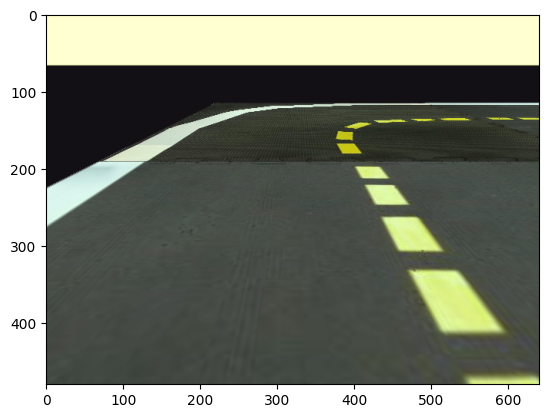

In [12]:
if execution == 'colab': 
    display = Display(visible=0, size=(1400, 900))
    display.start()
    window = pyglet.window.Window()
env = gym.make(map_name)
env.unwrapped.user_tile_start = [0,1]
env.unwrapped.start_pose = [[0.21699990272521976, 0, 0.41029359288296474], np.pi/2]
imshow(env.reset(), ax = plt, show = True)

In [26]:
import io
def savePlot(fig):
    with io.BytesIO() as buff:
        fig.savefig(buff, format='raw')
        buff.seek(0)
        data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
    w, h = fig.canvas.get_width_height()
    im = data.reshape((int(h), int(w), -1))
    return im

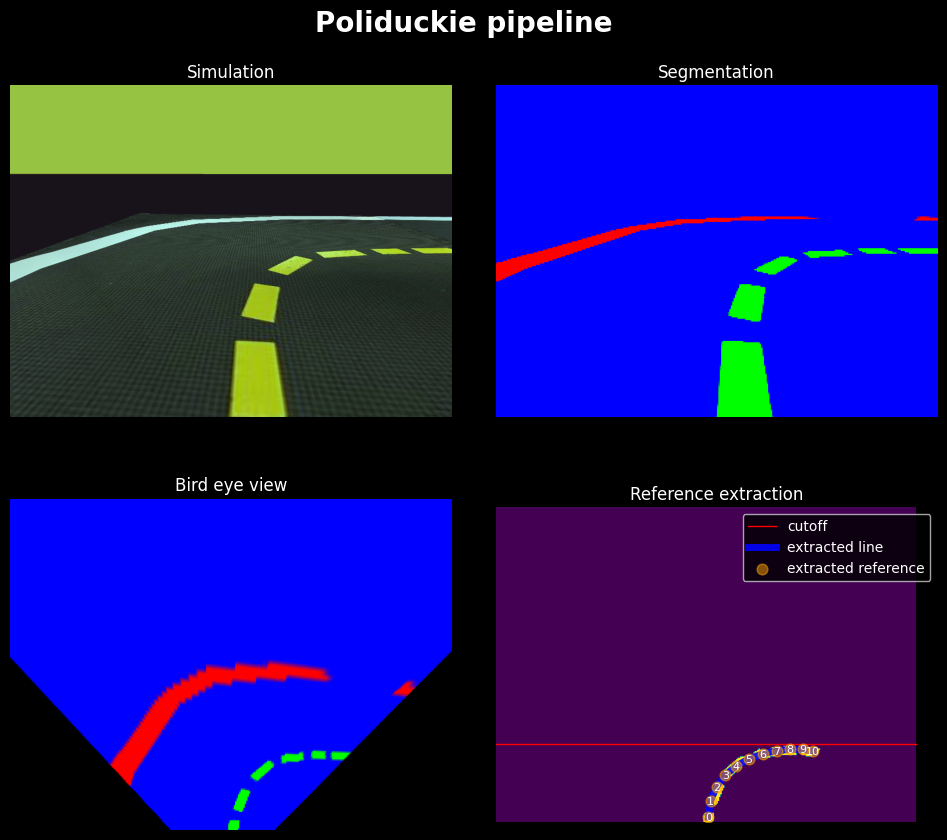

+-------+
| Frame |
+-------+
|  199  |
+-------+
+---------------------------------------------------------+
|                        MPC State                        |
+-----+-----+--------+--------------------+---------------+
|  x  |  y  | angle  | longitudinal speed | angular speed |
+-----+-----+--------+--------------------+---------------+
| 0.0 | 0.0 | 1.5708 |       0.3432       |      0.0      |
+-----+-----+--------+--------------------+---------------+
+---------------------+
|      MPC Action     |
+----------+----------+
| throttle | steering |
+----------+----------+
|   1.0    |   0.0    |
+----------+----------+


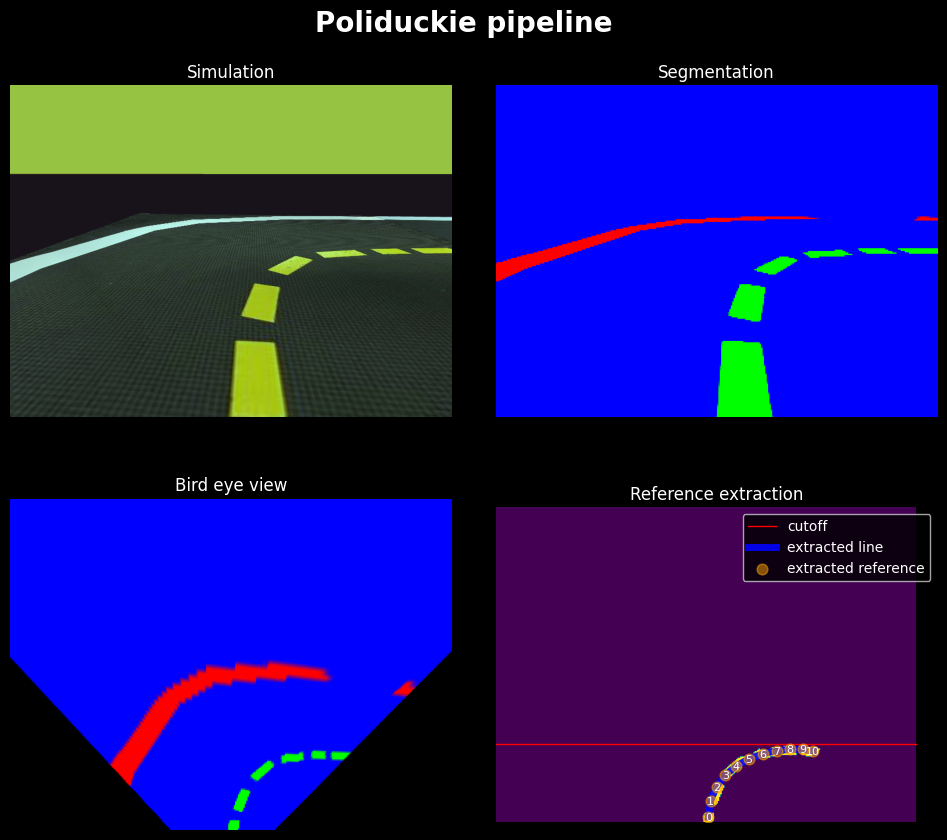

In [51]:
from poliduckie_segmentation.model import Model
import casadi as ca
import time
from matplotlib.animation import FuncAnimation
from prettytable import PrettyTable
from IPython import display
from IPython.display import clear_output

import imageio


VERTICAL_CUTOFF = 180
STEERING_CLIPPING = 3

# Number of frames
FRAMES = 200
# Number of frames to skip before displaying the next frame
DISPLAY_EVERY = 1

#==== PLOT SETUP ===============================================================
#Plot style
plt.style.use('dark_background')

# Create a figure and a set of subplots.
fig, axs = plt.subplots(2, 2)

#Set the size of the figure
fig.set_size_inches(10, 9)
fig.tight_layout()

#Set the plot title
fig.suptitle('Poliduckie pipeline', fontsize=20, fontweight='bold')

#Set the subplots title
axs[0,0].set_title('Simulation')
axs[0,1].set_title('Segmentation')
axs[1,0].set_title('Bird eye view')
axs[1,1].set_title('Reference extraction')

#adjust size of the subplots
fig.subplots_adjust(top=0.92)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

#remove axis from the subplots
for ax in axs.flat:
    ax.label_outer()
    ax.axis('off')
#==============================================================================

# State X = [x, y, angle, longitudinal speed, angular speed]
state = ca.DM([0,0,np.pi / 2,0,0])

F = Model()

image_recording = []

env.reset()

for frame_number in range(FRAMES):
  #==== LOGIC =====================================================================================
  #Reset the environment
  image = env.render(mode="rgb_array")
  image_BGR = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

  #Segmentation
  image_segmentation = (segmentation(image_BGR)[0]*255).clip(0, 255).astype(np.uint8)
  img_size_y = image_segmentation.shape[0]

  #Bird eye view
  image_birdeye = birdEyeTransform(image_segmentation).clip(0, 255).astype(np.uint8)

  #Line extraction
  dottedLineMask = cv2.threshold(image_birdeye[:, :, 1], 70, 255, cv2.THRESH_BINARY)[1]
  #imshow(dottedLineMask, ax = axs[1,0], show=False, no_axis=False)
  dottedLineMaskCropped = dottedLineMask[VERTICAL_CUTOFF:, :]
  line = lineExtraction(dottedLineMaskCropped, mode='bezier', n_points=N+1, img_height=img_size_y, vertical_cutoff=VERTICAL_CUTOFF)

  #Compute reference
  reference = computeReference(line, N+1, VERTICAL_CUTOFF, img_size_y)
  
  #Compute action
  action = runMpc(state, reference)

  #Clip the steering
  action[1] = np.clip(action[1], -STEERING_CLIPPING, STEERING_CLIPPING)

  #Update state
  state = F.step(*state.toarray().reshape(-1), action)

  #Recenter state
  state = ca.DM([0, 0, np.pi / 2, state[-2], state[-1]])

  #Execute action
  env.step(action)
  #================================================================================================

  #==== DISPLAY =====================================================================================
  if frame_number % DISPLAY_EVERY == 0:
    #Clear the output
    clear_output(wait=True)

    #==== PLOTS ===========================================================================
    #clear the plots
    axs[0,0].clear()
    axs[0,1].clear()
    axs[1,0].clear()
    axs[1,1].clear()

    #Set the subplots title
    axs[0,0].set_title('Simulation')
    axs[0,1].set_title('Segmentation')
    axs[1,0].set_title('Bird eye view')
    axs[1,1].set_title('Reference extraction')

    #remove axis from the subplots
    for ax in axs.flat:
        ax.label_outer()
        ax.axis('off')

    #display the simulation
    imshow(image, ax = axs[0,0], show=False, no_axis=False)

    #display the segmentation
    imshow(image_segmentation, ax = axs[0,1], show=False, no_axis=False)

    #display the bird eye view
    imshow(image_birdeye, ax = axs[1,0], show=False, no_axis=True)

    #display the reference
    axs[1, 1].clear()
    axs[1, 1].set_title('Reference extraction')
    axs[1, 1].axis('off')
    axs[1, 1].imshow(dottedLineMask)
    axs[1, 1].plot([0, 320], [VERTICAL_CUTOFF, VERTICAL_CUTOFF], color='red', linewidth=1, label='cutoff')
    axs[1, 1].plot(line[0], line[1] + VERTICAL_CUTOFF, color='blue', linewidth=5, alpha=0.9, label='extracted line')
    axs[1, 1].scatter(line[0], line[1] + VERTICAL_CUTOFF, color='orange', s=60, marker='o', alpha = 0.5,  label='extracted reference', zorder=10)
    #plot reference number
    for i in range(len(line[0])):
      axs[1, 1].text(line[0][i], line[1][i] + VERTICAL_CUTOFF, str(i), color='white', fontsize=8, horizontalalignment='center', verticalalignment='center', zorder=11)
    axs[1, 1].legend(loc='upper right')


    #display the figure
    display.display(plt.gcf())

    image_recording.append(savePlot(plt.gcf()))
    #======================================================================================

    #==== TABLES ==========================================================================
    #print frame number using prettytable
    frameTable = PrettyTable()
    frameTable.field_names = ["Frame"]
    frameTable.add_row([frame_number])
    print(frameTable)

    #print state using prettytable
    stateTable = PrettyTable()
    stateTable.title = 'MPC State'
    stateTable.field_names = ['x', 'y', 'angle', 'longitudinal speed', 'angular speed']
    #limit to 4 decimal
    stateTable.add_row([round(x, 4) for x in state.toarray().reshape(-1)])
    print(stateTable)

    #print action using prettytable
    actionTable = PrettyTable()
    actionTable.title = 'MPC Action'
    actionTable.field_names = ['throttle', 'steering']
    #limit to 4 decimal
    actionTable.add_row([round(x, 4) for x in action])
    print(actionTable)
    #======================================================================================
  #================================================================================================

#save the animation
imageio.mimsave('../animation.gif', image_recording, fps=10)